In [4]:
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d.axes3d import get_test_data
from mpl_toolkits.mplot3d import Axes3D
from fenics import *
from mshr import *
import numpy as np
from dotenv import load_dotenv
from scipy.ndimage import zoom
from scipy.interpolate import interp1d
import os
set_log_level(30)
# Cargar las variables del archivo .env
load_dotenv()

True

In [5]:
nueva_ruta = '/media/erick/TOSHIBA EXT/tests'

In [6]:
# Define time parameters
T = float(os.getenv('T'))
dt = float(os.getenv('dt'))
nb = int(os.getenv('nb'))
save_images = os.getenv('SAVE_IMAGES')

# Define time parameters
T = float(os.getenv('T'))
dt = float(os.getenv('dt'))
nb = 1


# Define mesh and space
nodes_in_xaxis=200
nodes_in_yaxis=200
space_size=70


os.chdir(nueva_ruta)

In [8]:
# Parámetros de entrada
field1_name = "c"  # Campo c (cáncer)
field2_name = "s"  # Campo s (células sanas)

In [9]:
def power_spectrum(field_name, t, block):
    """
    Calcula el espectro de potencia 2D en el espacio de Fourier y lo guarda normalizado.
    """
    field_file = f"matrix_{field_name}_{t:.3f}_nb_{block}.txt"
    field = np.loadtxt(field_file, float)
    # field = np.rot90(field, k=1, axes=(0, 1))  # Rotación según necesidad

    # Transformada de Fourier
    fft_field = np.fft.fft2(field)
    fft_field = np.fft.fftshift(fft_field)
    fft_field = np.abs(fft_field)

    # Eliminar la frecuencia cero (componente DC)
    # max_fft = np.where(fft_field == fft_field.max())
    # fft_field[max_fft[0][0], max_fft[1][0]] = 0

    # Normalización: Dividir por la suma total para asegurar consistencia
    fft_field /= np.sum(fft_field)

    # Guardar el espectro de potencia normalizado
    dft_file = f"matrix_{field_name}_dft_{t:.3f}_nb_{block}.txt"
    np.savetxt(dft_file, fft_field, delimiter="\t")
    return field_file, dft_file

In [10]:
def calculate_correlation_from_fft(dft_field1, dft_field2, field1_name, field2_name, step, block):
    """
    Calcula la función de correlación cruzada normalizada a partir de los espectros de Fourier,
    guarda el resultado en un archivo de texto, grafica la correlación y calcula la longitud de correlación.

    Args:
        dft_field1 (str): Ruta al archivo con el espectro de Fourier del primer campo.
        dft_field2 (str): Ruta al archivo con el espectro de Fourier del segundo campo.
        field1_name (str): Nombre del primer campo.
        field2_name (str): Nombre del segundo campo.
        step (float): Paso de tiempo.
        block (int): Número de bloque.

    Returns:
        np.ndarray: Función de correlación cruzada normalizada.
    """
    # Cargar los espectros de Fourier
    fft1 = np.loadtxt(dft_field1, delimiter="\t")
    fft2 = np.loadtxt(dft_field2, delimiter="\t")

    # Transformada inversa para obtener la correlación en el espacio real
    correlation = np.fft.ifft2(np.fft.fft2(fft1) * np.conjugate(np.fft.fft2(fft2))).real

    # Normalización
    correlation /= np.max(np.abs(correlation))

    # Centrar la correlación
    centered_correlation = np.fft.fftshift(correlation)

    # Guardar en un archivo txt
    corr_function_file = f"corr_fourier_{field1_name}_{field2_name}_{step:.3f}_block_{block}.txt"
    np.savetxt(corr_function_file, centered_correlation, delimiter="\t")
    print(f"Correlación normalizada guardada en {corr_function_file}")

    # Graficar la función de correlación
    # plot_correlation(centered_correlation, field1_name, field2_name, step, block)

    # Calcular el promedio radial de la correlación
    distances, radial_means = calculate_radial_average(centered_correlation)

    # Guardar el promedio radial en un archivo
    radial_avg_file = f"radial_corr_{field1_name}_{field2_name}_{step:.3f}_block_{block}.txt"
    np.savetxt(radial_avg_file, np.column_stack((distances, radial_means)), delimiter="\t", header="Distancia\tPromedio Radial")
    print(f"Promedio radial guardado en {radial_avg_file}")

    # Calcular la longitud de correlación a partir del promedio radial
    correlation_length = calculate_correlation_length_from_radial(distances, radial_means)

    # Graficar el promedio radial
    correlation_length = plot_radial_average(distances, radial_means, correlation_length, field1_name, field2_name, step, block)

    return correlation_length

In [11]:
def calculate_radial_average(matrix, dx=space_size/nodes_in_xaxis):
    """
    Calcula el promedio radial de una matriz 2D a partir de su centro, con escalado correcto.

    Args:
        matrix (np.ndarray): Matriz de la cual calcular el promedio radial.
        dx (float): Tamaño de celda en unidades físicas (default: espacio/número de nodos).

    Returns:
        tuple: (distancias en unidades físicas, promedios radiales)
    """
    rows, cols = matrix.shape
    center = (rows // 2, cols // 2)
    
    y, x = np.indices(matrix.shape)
    distances = np.sqrt((x - center[1])**2 + (y - center[0])**2) * dx  # Convierte a unidades físicas

    unique_distances = np.arange(0, distances.max(), dx)  # Paso en unidades físicas
    radial_means = np.zeros_like(unique_distances, dtype=float)

    for i, r in enumerate(unique_distances):
        mask = (distances >= r) & (distances < r + dx)  # Binning correcto en unidades físicas
        if np.any(mask):
            radial_means[i] = matrix[mask].mean()

    return unique_distances, radial_means

In [12]:
def calculate_correlation_length_from_radial(distances, radial_means):
    """
    Calcula la longitud de correlación a partir del promedio radial usando el criterio exponencial C(r) = e^-1.

    Args:
        distances (np.ndarray): Distancias desde el centro.
        radial_means (np.ndarray): Valores promedio de la correlación radial.

    Returns:
        float: Longitud de correlación.
    """
    threshold = np.exp(-1)
    mask = radial_means >= threshold
    if np.any(mask):
        correlation_length = distances[mask].mean()
    else:
        correlation_length = 0  
    return correlation_length

In [13]:
def plot_correlation(correlation, field1_name, field2_name, step, block):
    """
    Genera un gráfico 2D de la matriz de correlación cruzada.

    Args:
        correlation (np.ndarray): Matriz de la función de correlación.
    """
    plt.figure(figsize=(8, 6))
    plt.imshow(correlation, cmap="seismic", origin="lower")
    plt.colorbar(label="Correlación Normalizada")
    plt.title(f"Correlación {field1_name}-{field2_name} en t={step:.3f}")
    plt.xlabel("Desplazamiento en X")
    plt.ylabel("Desplazamiento en Y")
    plt.grid(False)
    plt.show()

In [14]:
def plot_radial_average(distances, radial_means, correlation_length, field1_name, field2_name, step, block):
    """
    Grafica el promedio radial de la correlación y marca la longitud de correlación en la gráfica.

    Args:
        distances (np.ndarray): Distancias desde el centro.
        radial_means (np.ndarray): Valores promedio de la correlación radial.
        correlation_length (float): Longitud de correlación calculada.
    """
    plt.figure(figsize=(8, 6))
    plt.plot(distances, radial_means, marker='o', linestyle='-', color='b', label='Promedio Radial')
    plt.axhline(y=np.exp(-1), color='r', linestyle='--', label=r'$e^{-1}$')

    plt.axvline(x=correlation_length, color='g', linestyle='--', label=f'Longitud de correlación: {correlation_length:.3f}')
    plt.scatter(correlation_length, np.exp(-1), color='g', zorder=3)

    plt.title(f"Promedio Radial {field1_name}-{field2_name} en t={step:.3f}")
    plt.xlabel("Distancia")
    plt.ylabel("Promedio radial")
    plt.grid(True, linestyle="--")
    plt.legend()
    plt.show()
    return correlation_length

block= 1
Correlación normalizada guardada en corr_fourier_c_s_0.000_block_1.txt
Promedio radial guardado en radial_corr_c_s_0.000_block_1.txt


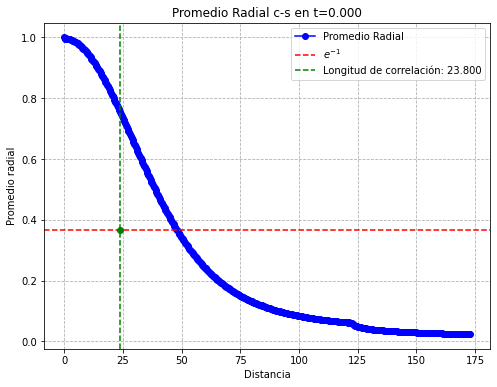

Correlación normalizada guardada en corr_fourier_c_s_0.005_block_1.txt
Promedio radial guardado en radial_corr_c_s_0.005_block_1.txt


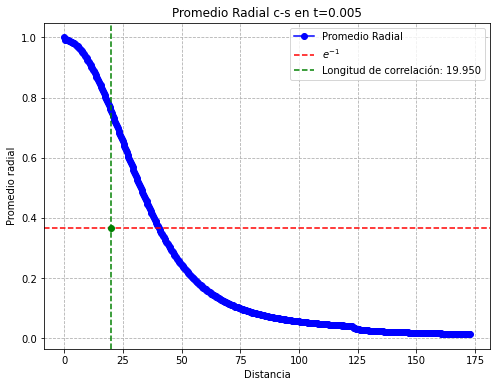

Correlación normalizada guardada en corr_fourier_c_s_0.010_block_1.txt
Promedio radial guardado en radial_corr_c_s_0.010_block_1.txt


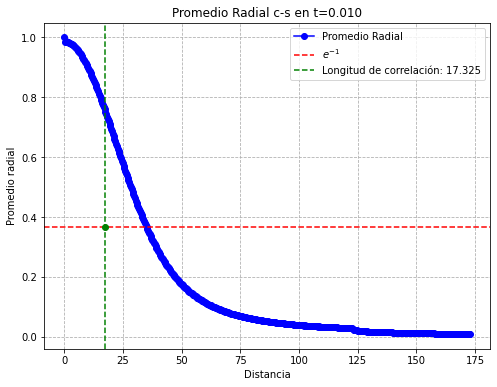

Correlación normalizada guardada en corr_fourier_c_s_0.015_block_1.txt
Promedio radial guardado en radial_corr_c_s_0.015_block_1.txt


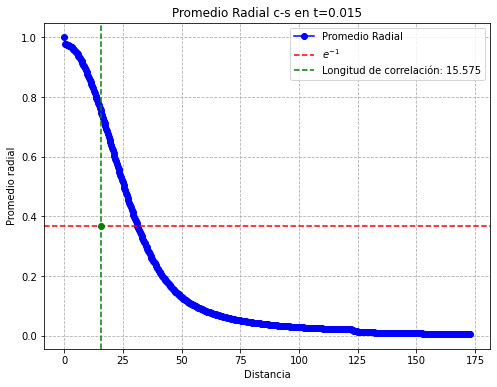

In [ ]:
corr_length_by_step = []

for block in range(1, nb + 1):
    t = 0
    print("block=", block)
    while t <= T:
        # Generar los espectros de potencia
        field_c, dft_field_c = power_spectrum('c', t, block)
        field_s, dft_field_s = power_spectrum('s', t, block)
        field_i, dft_field_i = power_spectrum('i', t, block)

        # Cargar los datos de los espectros
        dft_field_c_data = np.loadtxt(dft_field_c, float)
        dft_field_s_data = np.loadtxt(dft_field_s, float)
        dft_field_i_data = np.loadtxt(dft_field_i, float)

        # Igualar a cero el valor máximo en cada espectro
        dft_field_c_data[np.unravel_index(np.argmax(dft_field_c_data), dft_field_c_data.shape)] = 0
        dft_field_s_data[np.unravel_index(np.argmax(dft_field_s_data), dft_field_s_data.shape)] = 0
        dft_field_i_data[np.unravel_index(np.argmax(dft_field_i_data), dft_field_i_data.shape)] = 0

        # Guardar los espectros modificados para graficar
        np.savetxt(dft_field_c, dft_field_c_data, delimiter="\t")
        np.savetxt(dft_field_s, dft_field_s_data, delimiter="\t")
        np.savetxt(dft_field_i, dft_field_i_data, delimiter="\t")

        # Graficar los espectros modificados
        correlation_length = calculate_correlation_from_fft(dft_field_c, dft_field_s, field1_name, field2_name, t, block)
        corr_length_by_step.append([t, correlation_length])
        # Incrementar el tiempo
        t += dt
array_corr_step = np.array(corr_length_by_step)
nombre_archivo = f"correlation_length_fourier_steps_{field1_name}_{field2_name}.txt"
np.savetxt(nombre_archivo, array_corr_step, delimiter="\t")